# **STAT-201 Project Report**

## Comparison of the rate of `Offences Against a Person` before and during the outbreak of COVID-19 in Vancouver, Canada
Zicheng Zhao, Shariq Imran Hassan, Yandong Huang, Wenhan Zhang

## Introduction
Crime rates are one of the key indicators of community safety, and major social events such as political change and public health emergency of international concern can have the potential to impact and destabilize crime rates.

Based on the most recent major health emergency event: COVID-19, we will use the time point of this outbreak, i.e. Early 2020, as the dividing line, to compare the crime rates in Vancouver **three years ago (2017-2019)** and **three years later (2020-2022)**.

### Research Question
In this project, the main question which we want to figure out is:
#### *`Have` **`Offences Against a Person`** `been influenced by the outbreak of COVID-19?`*

### Dataset
Our dataset contains crime information in Vancouver (all regions covered according to `VPD Open Data`) from 2017-2022, and including information such as:
- `TYPE`: The type of crime activities.
- `YEAR`, `MONTH`, `DAY`, `HOUR`, `MINUTE`: The time when the reported crime activity occured. (Based on the finding of the police investigation.)
- `HUNDRED_BLOCK`: Generalized location of the reported crime activity.
- `NEIGHBOURHOOD`: The name of the neighbourhood where the location of the reported crime activity was belonged to.
- `X`, `Y`: Coordinate Values. 

### Analysis
We aim to analyze `Offence Against a Person` data from subsetting `TYPE` of crime and to use it's timelime, count and location to understand its fluctutations before and after COVID. We will use `YEAR` to understand the timeline and `NEIGHBOURHOODS`.


For more information, please take a look at the website: https://vpd.ca/

# Preliminary Results

First, we need to load the necessary libraries:

In [1]:
library(tidyverse)
library(GGally)
library(tidymodels)
library(broom)
library(repr)
library(infer)
library(ggplot2)
library(tidyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  mas

### 1. Loading the dataset

We first downloaded the dataset to our repository and read it from there as we cannot read datasets' directly from vpd's website.

Then the next thing we do is to take a glance at the dataset to see what it looks like.

In [2]:
crime <- read.csv("crime_data/merged_csv_files.csv")
head(crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,8,29,21,30,19XX TURNER ST,Grandview-Woodland,495232.4238,5458486.6121
2,Theft from Vehicle,2017,12,25,21,0,19XX UPLAND DR,Victoria-Fraserview,495089.4532,5451695.1098
3,Theft from Vehicle,2017,3,24,22,30,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
4,Theft from Vehicle,2017,10,23,9,22,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
5,Theft from Vehicle,2017,7,3,21,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018
6,Theft from Vehicle,2017,11,10,16,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018


**Table 1:** Preview of the crime data dataset to be analyzed.

### 2. Cleaning and Wrangling Data

We first need to clean the data and get rid of any NA values our datset might have. Therefore, now we filter out any NA data in the specific columns we feel we might need to analyze in our model. The `YEAR` column had an unusual string type which needed to be adressed and changed as well. 

Since we are also only focusing on the years from 2017 to 2022 (COVID Timeline), we subset the `YEAR` column.

In [3]:
crime <- crime %>%
        filter(!is.na(NEIGHBOURHOOD)) %>%
        filter(!(YEAR == "YEAR")) %>%
        filter(!is.na(YEAR)) %>%
        filter(!is.na(MONTH)) %>%
        filter(!is.na(TYPE)) %>%
        subset(YEAR >= 2017 & YEAR <= 2022)

head(crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,8,29,21,30,19XX TURNER ST,Grandview-Woodland,495232.4238,5458486.6121
2,Theft from Vehicle,2017,12,25,21,0,19XX UPLAND DR,Victoria-Fraserview,495089.4532,5451695.1098
3,Theft from Vehicle,2017,3,24,22,30,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
4,Theft from Vehicle,2017,10,23,9,22,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
5,Theft from Vehicle,2017,7,3,21,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018
6,Theft from Vehicle,2017,11,10,16,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018


**Table 2:** Preview of the cleaned and filtered crime data dataset.

Now we would like to see the different `TYPE`'s of crime we have and its number of occurences from 2017 to 2022.

In [4]:
# Filter for TYPE of data and number of occurences
crime_type <- crime %>%
    group_by(TYPE) %>%
    summarize(n = n())

crime_type

TYPE,n
<chr>,<int>
Break and Enter Commercial,13553
Break and Enter Residential/Other,11953
Homicide,93
Mischief,34042
Offence Against a Person,21087
Other Theft,63346
Theft from Vehicle,70143
Theft of Bicycle,11554
Theft of Vehicle,6623


**Table 3:** Preview of `TYPE` and number of occurences of each crime (2017-2022)

Here we can see that we have 11 different categories for crime with the most occurences being 'Theft from Vehicle (70143)', and the least being 'Vehicle Collision or Pedestrian Struck (with Fatality) (87)'. Because we are also only focusing on `Offence Against a Person` from the `TYPE` data, we will filter `TYPE` data.

In [5]:
# Filtering `Type`
crime <- crime %>%
        filter((TYPE == "Offence Against a Person"))

head(crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Offence Against a Person,2017,7,1,0,0,OFFSET TO PROTECT PRIVACY,West End,0.0,0.0
2,Offence Against a Person,2017,2,14,0,0,OFFSET TO PROTECT PRIVACY,West End,0.0,0.0
3,Offence Against a Person,2017,5,28,0,0,OFFSET TO PROTECT PRIVACY,West End,0.0,0.0
4,Offence Against a Person,2017,9,22,0,0,OFFSET TO PROTECT PRIVACY,West End,0.0,0.0
5,Offence Against a Person,2017,7,1,0,0,OFFSET TO PROTECT PRIVACY,West End,0.0,0.0
6,Offence Against a Person,2017,10,31,0,0,OFFSET TO PROTECT PRIVACY,West End,0.0,0.0


**Table 4:** Preview of `Offence Against a Person` crime `TYPE`

### 3. Plots

Now we can do a simple plot of `Offence Against a Person` crime rate from 2017-2022 to see its general tendency.

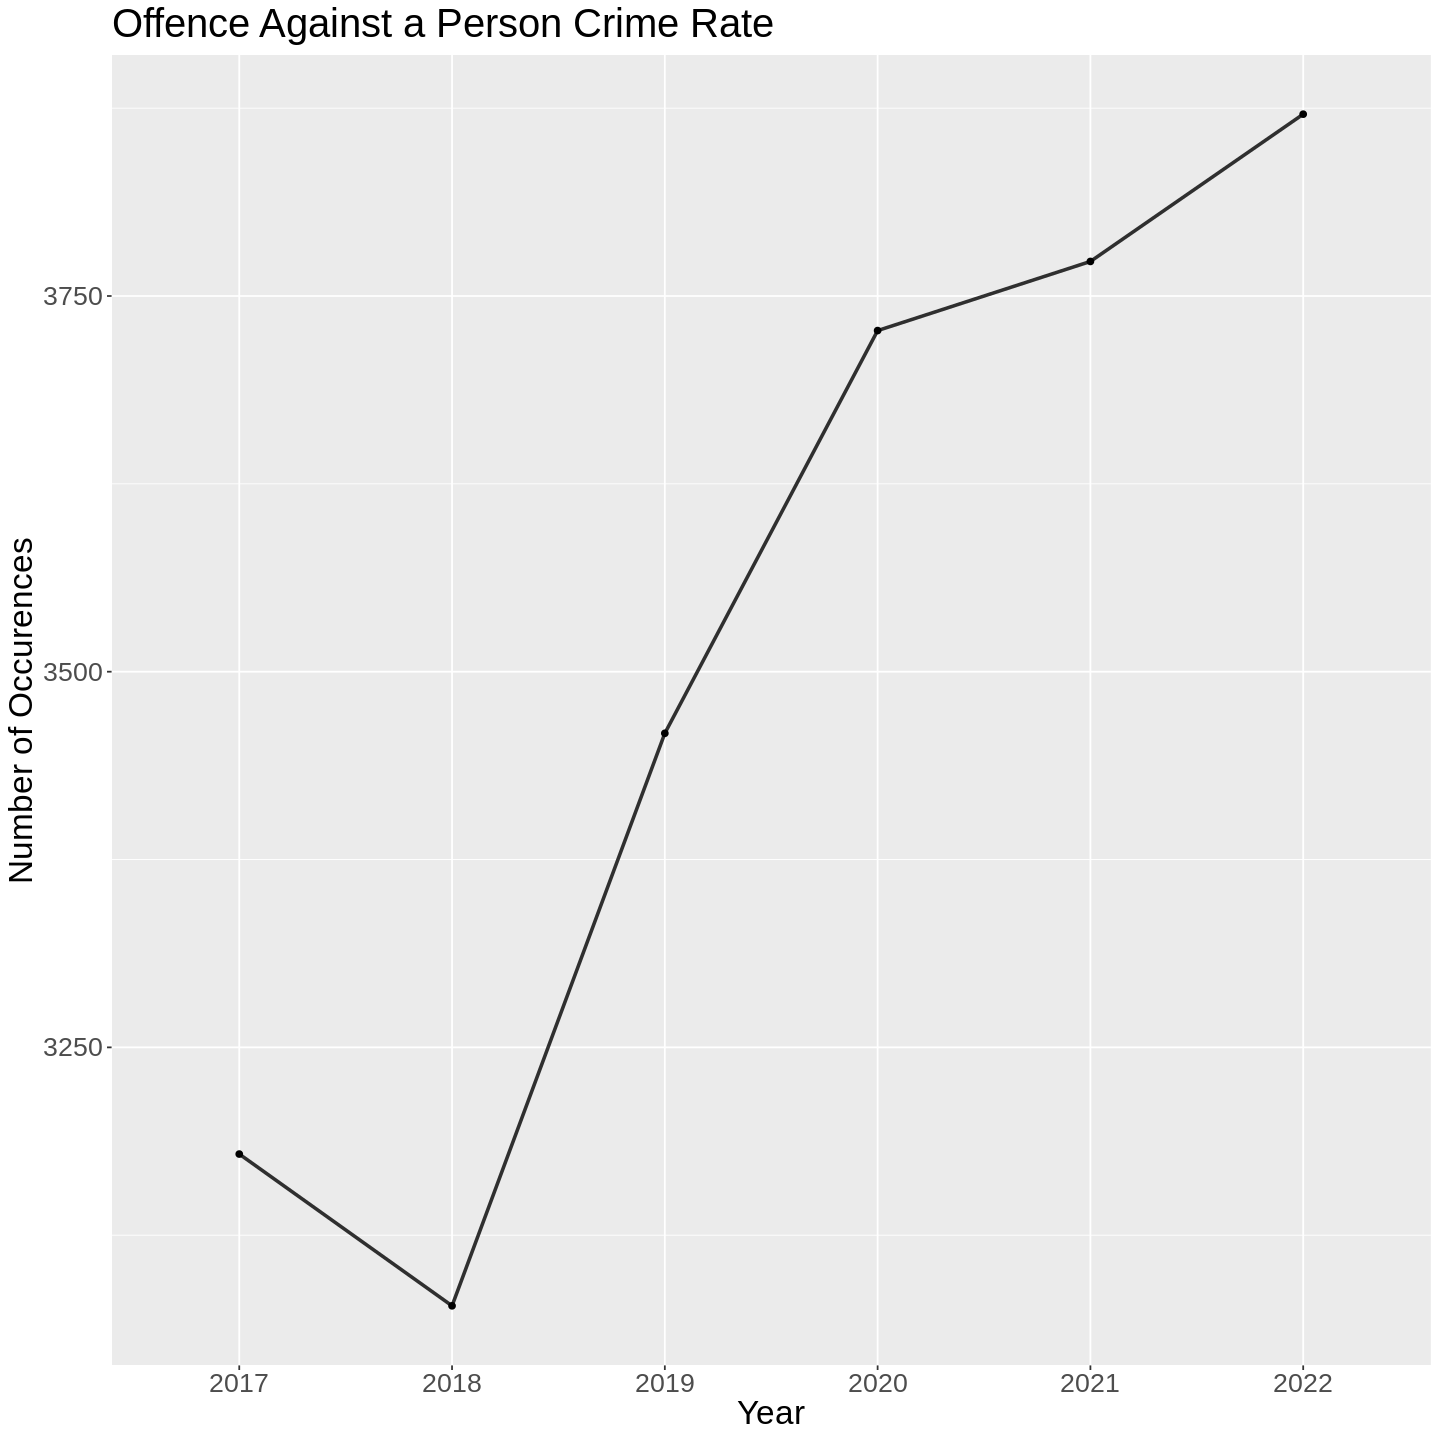

In [6]:
# Group Data by YEAR
annual_offence_crime <- crime %>%
               group_by(YEAR) %>%
               summarise(CRIME = n())

# Plot Annual Crime Data vs. Year
annual_offence_crime_plot <- annual_offence_crime %>%
               ggplot(aes(x = YEAR, y = CRIME, group = 1)) +
               geom_line(size = 1, alpha = 0.8) +
               geom_point() +
               ggtitle("Offence Against a Person Crime Rate") +
               labs(x = "Year", y = "Number of Occurences") +
               theme(text = element_text(size = 20))

options(repr.plot.width = 12, repr.plot.height = 12)

annual_offence_crime_plot

**Figure 1:** Line Graph for Number of of Offences Against a Person per Year.

From the visualized plot above, we can observe that since the outbreak of COVID-19 occurred in 2019, the crime ratio had a precipitous increase. We assume that the pandemic increased social disputes and offences potentially because of lay offs and isolation which may have impacted many mentally.

According to the background of the pandemic, we would do analysis at specific locations using the `NEIGHBOURHOOD` column. Therefore, we would first filter out the columns not required, to simplify the chart.

In [7]:
# Selecting Columns
crime <- crime %>%
     select(TYPE, YEAR, MONTH, DAY, NEIGHBOURHOOD)

head(crime)

,TYPE,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Offence Against a Person,2017,7,1,West End
2,Offence Against a Person,2017,2,14,West End
3,Offence Against a Person,2017,5,28,West End
4,Offence Against a Person,2017,9,22,West End
5,Offence Against a Person,2017,7,1,West End
6,Offence Against a Person,2017,10,31,West End


**Table 5:** Dataframe with the required columns.

Now we have a a clean dataset ready for more analysis!

### 4. Comparing Crime Rates at different `NEIGHBOURHOODS`'s before and during COVID

Next, we would visualize this comparison as a plot by grouping by `NEIGHBOURHOOD` and `YEAR` and observing where this type of crime happened more frequently.

For the column `YEAR`, because we treat the outbreak of COVID-19 as the time point, we would combine the data of 2017-2019, and 2020-2022 together respectively.

In [8]:
# Refactor `YEAR` column into `COVID_OUTBREAK` column
out_break <- crime %>%
    mutate(COVID_OUTBREAK = case_when(
        YEAR <= 2019 ~ "Before_COVID",
        YEAR >= 2020 ~ "During_COVID"
    ))

# Group by `NEIGHBOURHOOD` and `COVID_OUTBREAK` for analysis
criming <- out_break %>%
    group_by(NEIGHBOURHOOD, COVID_OUTBREAK) %>%
    count() %>%
    spread(key = NEIGHBOURHOOD, value = n, fill = 0)

transposed_crime <- t(criming)

transposed_crime


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.”


COVID_OUTBREAK,Before_COVID,During_COVID
V1,6,7
Arbutus Ridge,34,51
Central Business District,3297,3902
Dunbar-Southlands,50,66
Fairview,223,292
Grandview-Woodland,592,659
Hastings-Sunrise,264,297
Kensington-Cedar Cottage,369,413
Kerrisdale,47,52
Killarney,152,166


**Table 6:** Before and During COVID crime rates' of different `NEIGHBOURHOODS` for `Offence Against a Person`

Now we get the general data of the amount of offences before covid and during covid in `NEIGHBOURHOOD`'s, and we can visualize them to do a comparison and observe which `NEIGHBOURHOOD` has an abnormal change.

Now the data is generally clean and we have necessary knowledge to explore the dataset more!

# Exploring the dataset

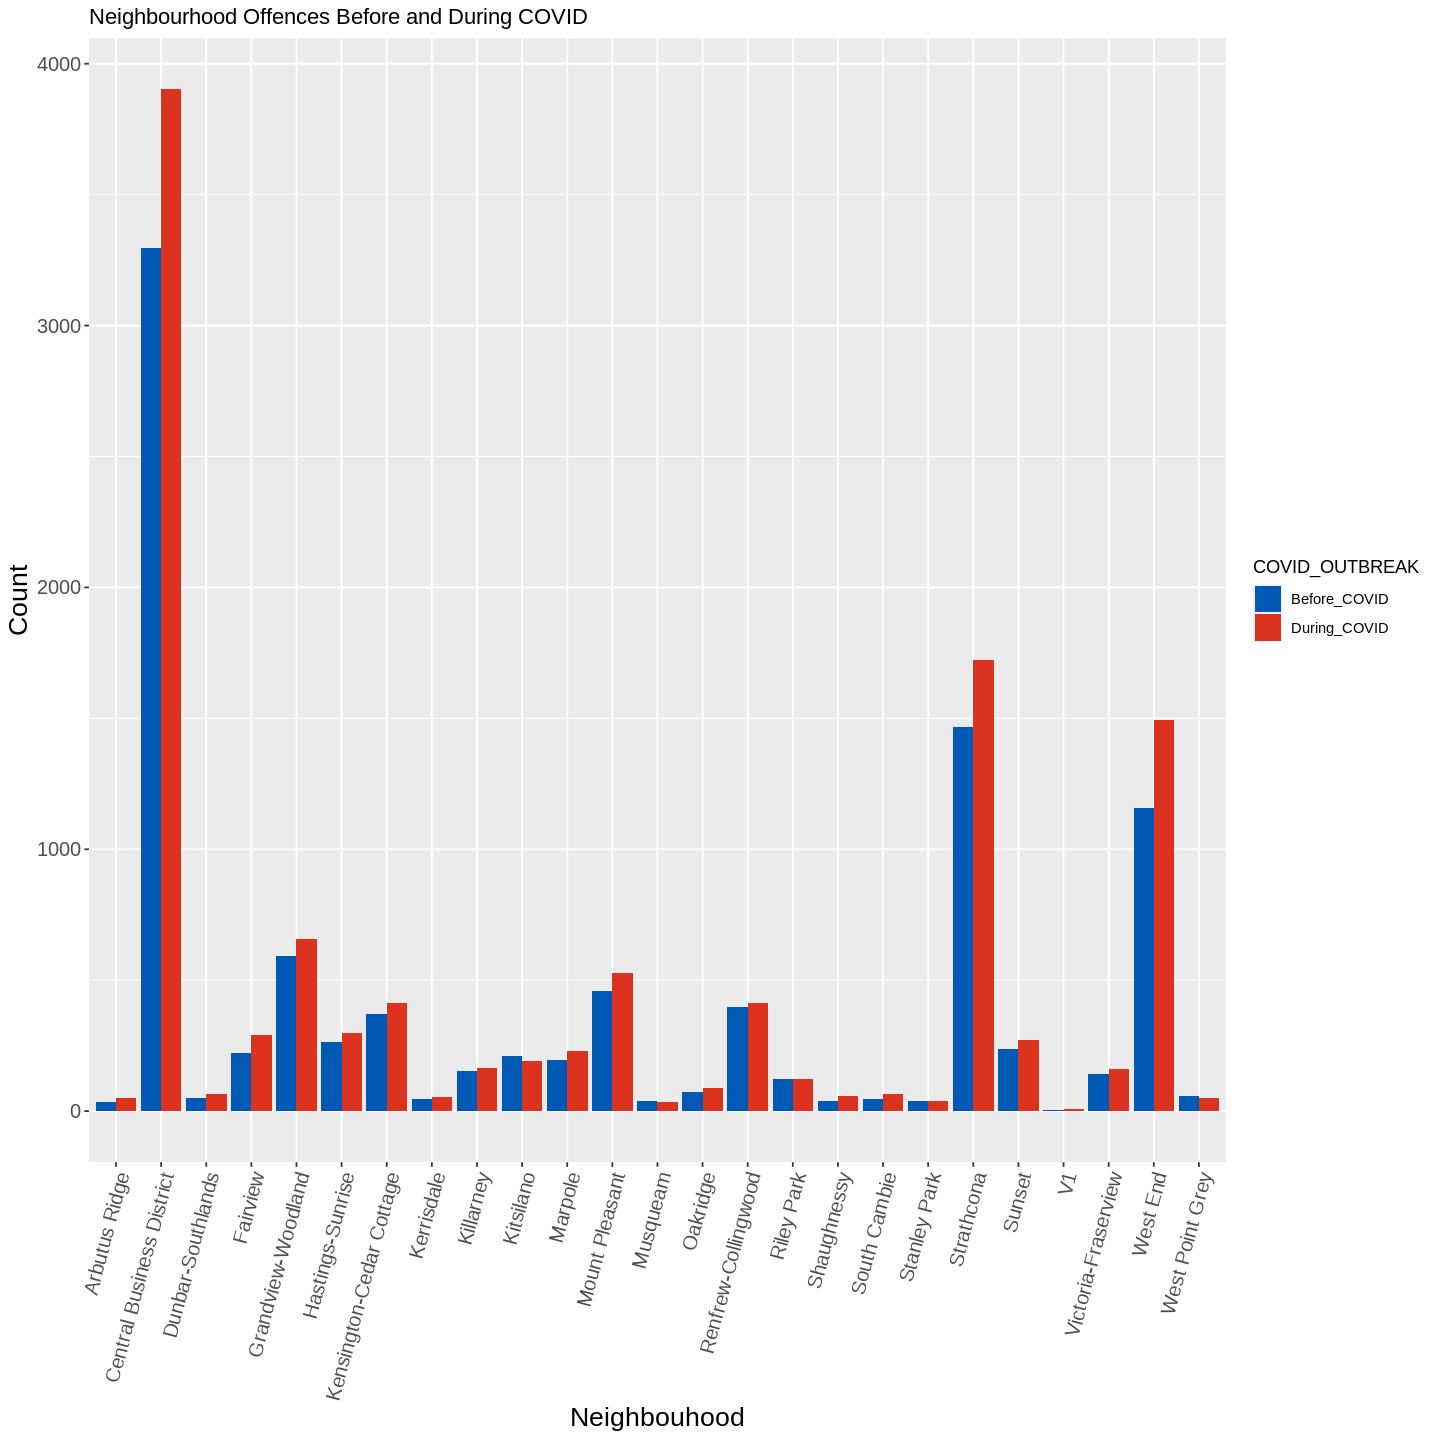

In [9]:
# Set Seed for Reproducible Analysis
set.seed(123)

# Transforming criming into DF
frame_crime <- as.data.frame(criming)

# Transforming frame_crime DF
frame_crime_long <- pivot_longer(frame_crime, 
                                 -COVID_OUTBREAK,
                                 names_to = "Neighbourhood",
                                 values_to = "Value")

# Plotting Neighbourhood Crime Before vs. During COVID
diff_crime_plot <- frame_crime_long %>%
    ggplot(aes(x = Neighbourhood, y = Value, fill = COVID_OUTBREAK)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("#005AB5", "#DC3220")) + # Using Colourblind Friendly Colours
    labs(x = "Neighbouhood", y = "Count", fill = "COVID_OUTBREAK") +
    ggtitle("Neighbourhood Offences Before and During COVID") +
    theme(axis.text.x = element_text(angle = 75, vjust = 1, hjust = 1),
          axis.text = element_text(size = 12),
          axis.title = element_text(size = 16))

options(repr.plot.width = 12, repr.plot.height = 12)

diff_crime_plot

**Figure 2:** Bar Chart for occurence of Offences Before and During COVID.

As we can see from the bar chart above, the ratio of offences have generally increased, while some of them have increased/decreased only slightly. By observing, we find `'Central Business District'` and `'Strathcona'` and `'West End'` to have a significant increase  compared to other `NEIGHBORUHOOD`'s.

Now we would like to analyze the overall change in `Offence Against a Person` from 2017 to 2022.

### 5. Analyzing Crime 'TYPE' `Offence Against a Person`

In [10]:
# Filtering Crime 'TYPE' to be `Offence Against a Person`
crime_for_offence <- crime %>%
    filter(TYPE == "Offence Against a Person") %>%
    select('YEAR','MONTH', 'DAY', 'NEIGHBOURHOOD')

head(crime_for_offence)

,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<chr>,<chr>,<chr>
1,2017,7,1,West End
2,2017,2,14,West End
3,2017,5,28,West End
4,2017,9,22,West End
5,2017,7,1,West End
6,2017,10,31,West End


**Table 6:** Preview of data on Crime TYPE: `'Offence Against a Person'`

Now we convert `YEAR` and `MONTH` columns to a date format and seperate the time as before and after the outbreak of COVID-19.

*(Y/M/D)*

**Before COVID:** *2017-07-01* to *2020-01-01*

**After COVID:** *2020-01-01* to *2022-11-01*

In [11]:
# Transform the time into the Date format
crime_for_offence$DATE <- as.Date(paste(crime_for_offence$YEAR, 
                                        crime_for_offence$MONTH,
                                        "01",
                                        sep = "-"), 
                                  format = "%Y-%m-%d")

# Double check by filtering the date into the range we would target generally.
subset_data <- subset(crime_for_offence, crime_for_offence$DATE >= as.Date("2017-01-01") &
                                         crime_for_offence$DATE <= as.Date("2022-12-31"))

# Seperate the dataset into two parts according to the outbreak of COVID-19.
subset_data$OUTBREAK <- ifelse(subset_data$DATE < as.Date("2020-01-01"), 
                               "Before", "After")

head(subset_data)
tail(subset_data)

,YEAR,MONTH,DAY,NEIGHBOURHOOD,DATE,OUTBREAK
,<chr>,<chr>,<chr>,<chr>,<date>,<chr>
1,2017,7,1,West End,2017-07-01,Before
2,2017,2,14,West End,2017-02-01,Before
3,2017,5,28,West End,2017-05-01,Before
4,2017,9,22,West End,2017-09-01,Before
5,2017,7,1,West End,2017-07-01,Before
6,2017,10,31,West End,2017-10-01,Before


,YEAR,MONTH,DAY,NEIGHBOURHOOD,DATE,OUTBREAK
,<chr>,<chr>,<chr>,<chr>,<date>,<chr>
21082,2022,8,23,Strathcona,2022-08-01,After
21083,2022,9,3,Strathcona,2022-09-01,After
21084,2022,9,19,Strathcona,2022-09-01,After
21085,2022,10,4,Strathcona,2022-10-01,After
21086,2022,10,20,Strathcona,2022-10-01,After
21087,2022,11,4,Strathcona,2022-11-01,After


**Table 7:** Preview of `'Offence Against a Person'` before COVID *(2017-07-01 to 2020-01-01)* and after *(2020-01-01 to 2022-11-01)*

Now we are going to create a frequency plot of crimes by month and year and stratified by the period before and after the outbreak of COVID-19, and convert it to a data frame and edit it slightly.

`summarise()` has grouped output by 'DATE'. You can override using the
`.groups` argument.


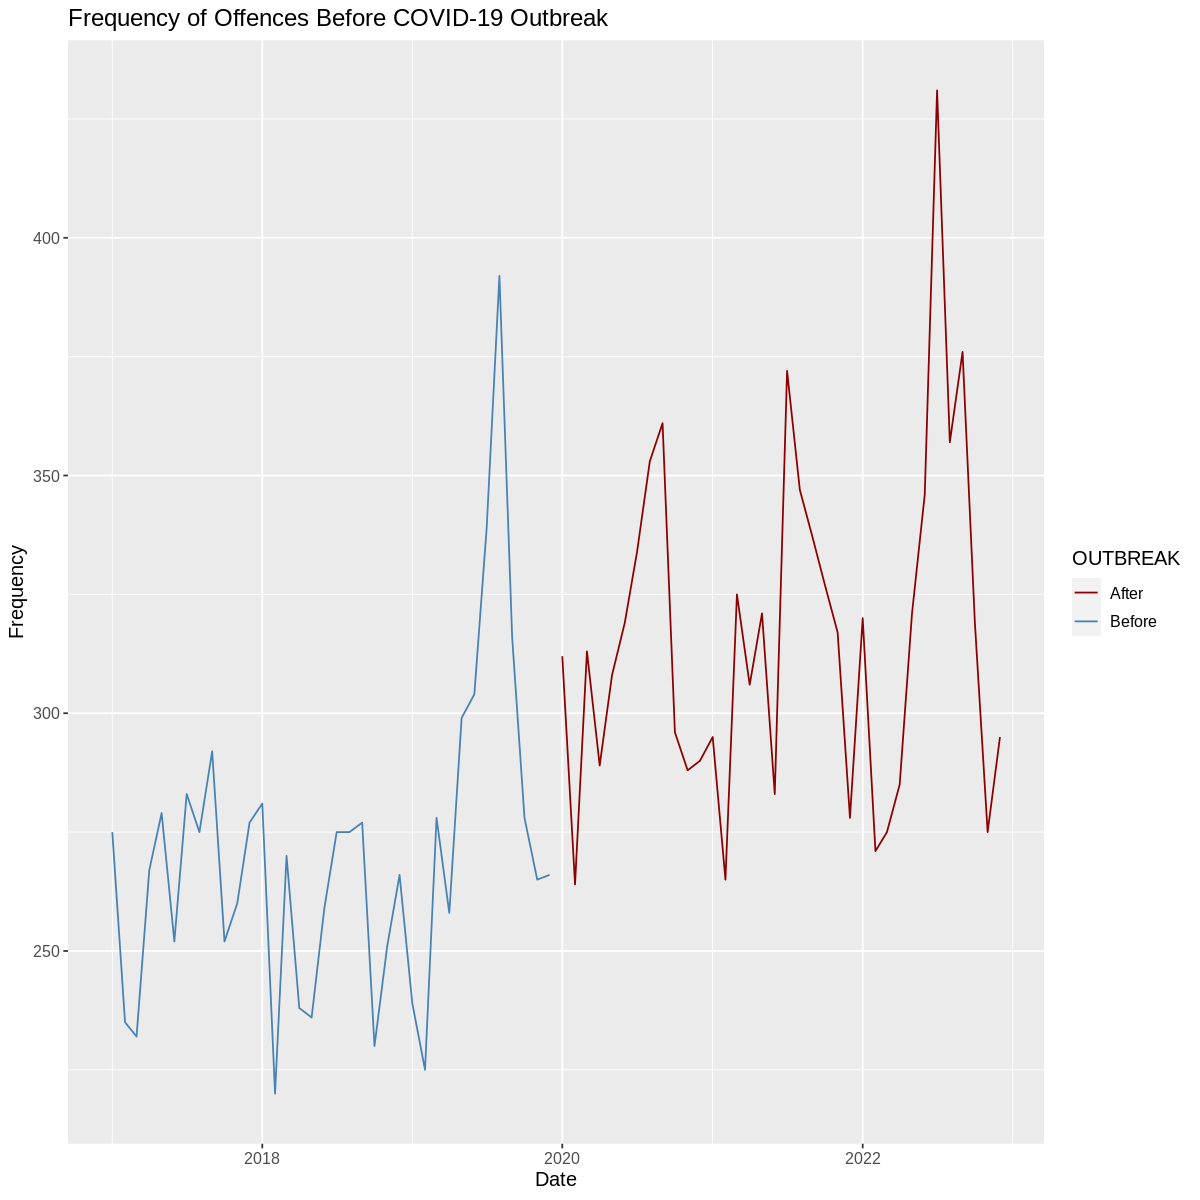

In [16]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Grouping data by Data and OUTBREAK
grouped_data <- subset_data %>%
    group_by(DATE, OUTBREAK) %>%
    summarize(count = n())

# Plotting Line Plot
frequency_plot <- grouped_data %>%
    ggplot(aes(x = DATE, y = count)) +
               geom_line(aes(color = OUTBREAK)) +
               scale_color_manual(values = c("darkred", "steelblue")) + 
               ggtitle("Frequency of Offences Before COVID-19 Outbreak") +
               labs(x = "Date", y = "Frequency") +
               theme(text = element_text(size = 12))
frequency_plot

**Figure 3:** Line Plot of Crime Frequency Before and After COVID. 

(We can observe how it is an overall increase)

# Mehtods

## Plans

# Performing Data Analysis

### 6. Analysis of `Offence Against a Person` (Using the whole of Vancouver) 
Now we want to perform bootstrapping to analyze our data before and after COVID. We will be resampling the data and computing confidence intervals for the means.

In [14]:
# Load Library
library(boot)

ERROR: Error in library(boot): there is no package called ‘boot’


In [84]:
# Convert the date to a numeric format such as the number of days since a reference date.
before_data$days_since_outbreak <- as.integer(as.Date("2020-01-01") - before_data$DATE)
after_data$days_since_outbreak <- as.integer(after_data$DATE - as.Date("2020-01-01"))

# Extract the filtered date above
before_days <- before_data$days_since_outbreak
after_days <- after_data$days_since_outbreak


# Define a function to compute the mean of a sample
mean_func <- function(data, index) {
    mean(data[index])
}

# Perform bootstrap resampling
before_boot <- boot(before_data$days_since_outbreak, mean_func, R = 1000)
after_boot <- boot(after_data$days_since_outbreak, mean_func, R = 1000)

# Compute the confidence intervals for the means
before_ci <- boot.ci(before_boot, type = "perc")
after_ci <- boot.ci(after_boot, type = "perc")

# Print the confidence intervals
print(before_ci)
print(after_ci)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = before_boot, type = "perc")

Intervals : 
Level     Percentile     
95%   (543.8, 556.0 )  
Calculations and Intervals on Original Scale
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = after_boot, type = "perc")

Intervals : 
Level     Percentile     
95%   (533.2, 545.3 )  
Calculations and Intervals on Original Scale


**Table 8:** Bootstrap Distribution with Confidence Intervals for Offense Crime Before and After COVID

Now that we have calculated the bootstrap distribution, let's visualize the bootstrapping distribution of means.

In [18]:
options(repr.plot.width = 12, repr.plot.height = 12)

# Create a data frame with the bootstrap means and labels
before_df <- data.frame(value = before_boot$t, group = "Before")
after_df <- data.frame(value = after_boot$t, group = "After")
df <- rbind(before_df, after_df)

# Create a histogram with confidence intervals
ggplot(df, aes(x = value, fill = group)) +
    geom_histogram(alpha = 0.5, position = "identity", bins = 500) +
    geom_vline(xintercept = before_ci$percent[1], linetype = "dashed", color = "darkred") +
    geom_vline(xintercept = before_ci$percent[2], linetype = "dashed", color = "darkred") +
    geom_vline(xintercept = after_ci$percent[1], linetype = "dashed", color = "steelblue") +
    geom_vline(xintercept = after_ci$percent[2], linetype = "dashed", color = "steelblue") +
    labs(title = "Bootstrap distribution of means",
         x = "Mean",
         y = "Frequency",
         fill = "Group") +
    theme(text = element_text(size = 12))

ERROR: Error in data.frame(value = before_boot$t, group = "Before"): object 'before_boot' not found


In [19]:
**Figure 4:** Bootstrap Distribution of Means

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected '^'
1: **
    ^


According to the graph above, the confidence intervals overlap substantially, it suggests that there may not be a statistically significant difference between the groups being compared.

However, it is not a definitive indication of the presence or absence of a statistically significant difference.

Let's perform hypothesis testing to determine whether there is a significant difference between the distributions of crimes before and after the outbreak.

We will use **t-test**, and then **check the p-value**.

In [20]:
# Doing t-test which includes p-value.
t.test(before_days, after_days)

ERROR: Error in t.test(before_days, after_days): object 'before_days' not found


**Table 9:** two-sample t-test on Before vs. After COVID Offences

From the result above, we can observed that the two-sample t-test is **less than 0.05**, which is 0.01559.

We can **reject the null hypothesis**.

And now we can tell that **there is significant difference in the mean frequency of crime** before and after the outbreak of COVID-19.

### 7. Analysis of `Offence Against a Person` (Analyzing the `Neighbourhoods` within Vancouver) 

Now we will try to do the **Hypothesis Test** for each `NEIGHBOURHOOD` :

We are going to compare the frequency of crime from 2017 to 2019 and 2020 to 2022 for each `NEIGHBOURHOOD` and obtain the p-value for each test.

In [22]:
# Filter and Select data from crime
crime_offence <- crime %>%
    filter(TYPE == "Offence Against a Person") %>%
    filter(NEIGHBOURHOOD != "") %>%
    select(YEAR, NEIGHBOURHOOD)

# Create a new column to indicate whether the crime happened from 2017 to 2019 or 2020 to 2022
crime_offence$period <- ifelse(crime_offence$YEAR %in% c(2017, 2018, 2019), "2017-2019", "2020-2022")

# Get a list of unique neighborhoods
neighborhoods <- unique(crime_offence$NEIGHBOURHOOD)

# Create an empty vector to store the p-values
p_values <- c()

for (n in neighborhoods) {
  # Subset the data for the current neighborhood
  neighborhood_data <- subset(crime_offence, NEIGHBOURHOOD == n)
  
  # Create a contingency table of crime frequency by year and period
  contingency_table <- table(neighborhood_data$YEAR, neighborhood_data$period)
  
  # Conduct a chi-square test of independence to compare the frequency of crime between the two periods
  chi_sq_test <- chisq.test(contingency_table)
  
  # Extract the p-value from the test result
  p_value <- chi_sq_test$p.value
  
  # Add the p-value to the vector
  p_values <- c(p_values, p_value)
}

# Print the p-values for each neighborhood
names(p_values) <- neighborhoods

# Convert the p-values to a data frame
p_values_df <- data.frame(NEIGHBOURHOOD = names(p_values), p_value = p_values)

# Create a tidy format using the gather function
tidy_p_values <- gather(p_values_df, key = "test", value = "p_value", -NEIGHBOURHOOD)

tidy_p_values

Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”


NEIGHBOURHOOD,test,p_value
<chr>,<chr>,<dbl>
West End,p_value,0.000000e+00
Stanley Park,p_value,1.358353e-15
Central Business District,p_value,0.000000e+00
Mount Pleasant,p_value,6.453203e-211
Strathcona,p_value,0.000000e+00
Grandview-Woodland,p_value,2.633585e-268
Kensington-Cedar Cottage,p_value,9.060487e-167
Hastings-Sunrise,p_value,5.382466e-119
Renfrew-Collingwood,p_value,1.781760e-173


**Table 10:** p-values of each Neighbourhood

As we can see from the chart above, according to the p_values for the `NEIGHBOURHOOD` column, they are generally super small.

It is in turn showing a strong evidence to support the assumption that the frequency of **`Offence Against a Person`** had a big fluctuation during the outbreak of COVID-19.

## Discussion

In this report, we tested the question of whether the crime rate was influenced by the outbreak of COVID-19 and which types of crime have abnormal fluctuations that need people to pay attention to. We first take a glance at the dataset to see what it looks like and do a comparison between different communities. We then found confidence intervals using bootstrapping, resampling the data, and  conducting hypothesis testing which revealed that there is significant difference in the mean frequency of crime before and after the outbreak of COVID-19. Finally, we do the Now we will try to do the hypothesis test on comparing the frequency and obtaining the p-value for each test. These p-values support the assumption that the frequency of Offence Against a Person had a big fluctuation during the outbreak of COVID-19.

## Methods 

## Plan

- What do we expect to find?
    - The fluctuation of the crime rate caused by the outbreak of COVID-19, and specific types of crime need to pay attention to.

- What impact could such findings have?
    - The findings will let people realize the impact that COVID-19 brought to us on the aspect of community security.

- What future questions could this lead to?
    - The project shows the tendency of crime rate when major social events happen, and give people and institutions guidance on how to make precautions and what should we expect.

## References:

- https://www.sfu.ca/research/scholarly-impacts/how-covid-19-lockdowns-affected-crime-vancouver

- https://vpd.ca/

- https://www.cbc.ca/amp/1.6078015